# <p style="padding:10px;background-color:#FF9900;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Amazon products Recommendation System</p>

## Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer,TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Input

%matplotlib inline

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:130%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Table Of Contents</p>   
    

    
|No  | Contents 
|:---| :---     
|1   | [<font color="#0f4c5c"> Processing Data </font>](#1)                  
|2   | [<font color="#0f4c5c">  BERT model fine tuning</font>](#2)                                

<a id='1'></a>
<p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:170%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Processing Data</p>

In the previous [notebook](#https://www.kaggle.com/imenbakir/part-ii-amazon-products-recommender-system) I've applied VADER to the dataset to categorize sentiment labels based on sentiment scores, I have also conducted Feature Extraction with Bag of Words and TF-IDF and trained some models to predict the sentiment of a review.

In this notebook I'm going to conduct transfer learning with BERT language model on my dataset and fine tune it so that we can compare its results with the other models.

In [3]:
software_df = pd.read_csv('/kaggle/input/filtered-dataset/filtered_dataset.csv')

In [4]:
software_df.head(1)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category,sentiment_score,sentiment_label
0,4,True,2014-03-11,A240ORQ2LF9LUI,0077613252,Michelle W,material arrived early excellent condition how...,material great,software,0.34,positive


In [5]:
columns = ['sentiment_score', 'sentiment_label']
software_df1 = software_df.drop(columns= columns , axis=1)

In [6]:
software_df1.head(1)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category
0,4,True,2014-03-11,A240ORQ2LF9LUI,0077613252,Michelle W,material arrived early excellent condition how...,material great,software


In [7]:
def assign_sentiment_label(score):
    """
     function to assign sentiment labels based on overall scores
    """
    
    if score >= 4:
        return 'positive'
    elif score < 3:
        return 'negative'
    else:
        return 'neutral'

#applying the function to create the sentiment_label column
software_df1['sentiment_label'] = software_df1['overall'].apply(assign_sentiment_label)

software_df1.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category,sentiment_label
0,4,True,2014-03-11,A240ORQ2LF9LUI,0077613252,Michelle W,material arrived early excellent condition how...,material great,software,positive
1,4,True,2014-02-23,A1YCCU0YRLS0FE,0077613252,Rosalind White Ames,really enjoying book worksheet make review goa...,health,software,positive
2,1,True,2014-02-17,A1BJHRQDYVAY2J,0077613252,Allan R. Baker,taking class do not waste money called book bo...,kiding,software,negative
3,3,True,2014-02-17,APRDVZ6QBIQXT,0077613252,Lucy,book missing page important page could not ans...,missing page,software,neutral
4,5,False,2013-10-14,A2JZTTBSLS1QXV,0077775473,Albert V.,used learnsmart officially say amazing study t...,best study product,software,positive


In [8]:
label_mapping = {"negative": 0, "positive": 1, "neutral": 2}
software_df1['sentiment_label'] = software_df1['sentiment_label'].map(label_mapping)

In [9]:
software_df1['sentiment_label'] 

0         1
1         1
2         0
3         2
4         1
         ..
450864    0
450865    0
450866    1
450867    1
450868    1
Name: sentiment_label, Length: 450869, dtype: int64

In [10]:
print("\nTotal number of reviews: ",len(software_df1))

print("=======================================================================")

print("\nTotal number of Sentiments: ", len(list(set(software_df1['sentiment_label'] ))))


Total number of reviews:  450869

Total number of Sentiments:  3


In [11]:
software_df1.isnull().sum()

overall               0
verified              0
reviewTime            0
reviewerID            0
asin                  0
reviewerName          0
reviewText          555
summary            1192
category              0
sentiment_label       0
dtype: int64

In [12]:
#replace NaN values with 'Unknown'
software_df1['reviewText'].fillna('Unknown', inplace=True)
software_df1['summary'].fillna('Unknown', inplace=True)

In [13]:
software_df1.isnull().sum()

overall            0
verified           0
reviewTime         0
reviewerID         0
asin               0
reviewerName       0
reviewText         0
summary            0
category           0
sentiment_label    0
dtype: int64

<a id='2'></a>
<p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:170%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">BERT model Fine Tuning </p>

### Fine Tuning BERT model

#### Tokenizing text

In [14]:
import numpy as np

software_df1['txt_len'] = software_df1['reviewText'].apply(lambda x: len(x.split(" ")))
max_seq_len = np.round(software_df1['txt_len'].mean() + 2 * software_df1['txt_len'].std()).astype(int)
max_seq_len

167

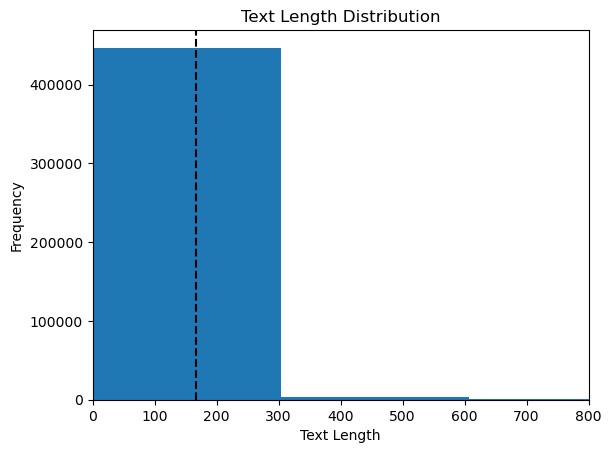

In [15]:
software_df1['txt_len'].plot.hist()
plt.xlim(0, 800)  # Set the x-axis limits
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.xlabel('Text Length')
plt.title('Text Length Distribution')
plt.show();

In [16]:
software_df1.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category,sentiment_label,txt_len
0,4,True,2014-03-11,A240ORQ2LF9LUI,0077613252,Michelle W,material arrived early excellent condition how...,material great,software,1,15
1,4,True,2014-02-23,A1YCCU0YRLS0FE,0077613252,Rosalind White Ames,really enjoying book worksheet make review goa...,health,software,1,12
2,1,True,2014-02-17,A1BJHRQDYVAY2J,0077613252,Allan R. Baker,taking class do not waste money called book bo...,kiding,software,0,28
3,3,True,2014-02-17,APRDVZ6QBIQXT,0077613252,Lucy,book missing page important page could not ans...,missing page,software,2,12
4,5,False,2013-10-14,A2JZTTBSLS1QXV,0077775473,Albert V.,used learnsmart officially say amazing study t...,best study product,software,1,50


#### Split data into Train and Test sets

In [17]:
train_df, val_df = train_test_split(software_df1, test_size=0.2, random_state=42)

print('Load %d training examples and %d validation data. \n' %(train_df.shape[0],val_df.shape[0]))
print('Show a review in the training set : \n', train_df['reviewText'].iloc[10])
print("=======================================================================")
print('Training Data : \n\n', train_df)
print("=======================================================================")
print('Testing data : \n\n', val_df)

Load 360695 training examples and 90174 validation data. 

Show a review in the training set : 
 using turbotax year seems get easier every time use efile make even simpler
Training Data : 

         overall  verified  reviewTime      reviewerID        asin  \
351553        4     False  2016-03-04  A17JRC14M34L71  B019QWTLAC   
433513        5      True  2018-03-12  A2KDFE5HWSWJ3D  B00I3O3LD8   
77504         2     False  2010-01-10  A3NHUQ33CFH3VM  B002EAYJD8   
374807        1     False  2004-11-14   AO6QR8ZYUQJZF  B00016W556   
420920        5      True  2014-03-05   ADC9WVQT8QVL1  B0086GBLI0   
...         ...       ...         ...             ...         ...   
259178        5      True  2015-09-21  A1A04XENP7ZZ82  B00MUY6KY4   
365838        5     False  2002-07-30  A3GBS2HNVVTTHW  B00005O1GD   
131932        5     False  2013-03-28   AWIF8AR75LL9L  B007QYZ08A   
146867        1      True  2013-08-31  A2FWLQXB5CDHOQ  B0095CATEG   
121958        5      True  2016-05-20   A39MUC66Q

#### Tokenize text & padding

In [18]:
example = software_df1['reviewText'][0]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer.tokenize(example)

['material',
 'arrived',
 'early',
 'excellent',
 'condition',
 'however',
 'money',
 'spent',
 'really',
 'should',
 'have',
 'come',
 'bind',
 '##er',
 'loose',
 'leaf']

In [19]:
tokenizer.encode(example)

[101,
 3430,
 3369,
 2220,
 6581,
 4650,
 2174,
 2769,
 2985,
 2428,
 2323,
 2031,
 2272,
 14187,
 2121,
 6065,
 7053,
 102]

#### Let’s prepare the data according to the format needed for the BERT model


**Input IDs –** The input ids are often the only required parameters to be passed to the model as input. Token indices, numerical representations of tokens building the sequences that will be used as input by the model.

**Attention mask –** Attention Mask is used to avoid performing attention on padding token indices. Mask value can be either 0 or 1, 1 for tokens that are NOT MASKED, 0 for MASKED tokens.

**Token type ids –** It is used in use cases like sequence classification or question answering. As these require two different sequences to be encoded in the same input IDs. Special tokens, such as the classifier[CLS] and separator[SEP] tokens are used to separate the sequences.

In [20]:
def convert_review_to_feature(review):
    return tokenizer.encode_plus(review,
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_seq_len, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

In [21]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    """
    Transform raw data to an appropriate format ready to feed into the BERT model.
    """
    return {
          "input_ids": input_ids,
          "token_type_ids": token_type_ids,
          "attention_mask": attention_masks,
      }, label

In [22]:
def encode_reviews(ds, limit=-1):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    if (limit > 0):
        ds = ds.take(limit)
        
    for review, label in zip(ds['reviewText'], ds['sentiment_label']):
        bert_input = convert_review_to_feature(review)
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [23]:
batch_size=32

**Let’s form our train and test dataset**

In [24]:
# train dataset
train_encoded = encode_reviews(train_df).shuffle(10000).batch(batch_size)
# test dataset
test_encoded = encode_reviews(val_df).batch(batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


**Model Configuration**

In [25]:
# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


**Customizing the model's hyperparameters and optimizer:**

In [26]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

number_of_epochs = 1

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

#### Training the BERT model for Sentiment Analysis

In [27]:
train_encoded

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 167), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 167), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 167), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>

In [28]:
bert_history = model.fit(train_encoded, epochs=1, validation_data=test_encoded)

11272/11272 [==============================] - 7651s 674ms/step - loss: 0.4284 - accuracy: 0.8399 - val_loss: 0.3763 - val_accuracy: 0.8586


#### Test on random sample

In [31]:
test_sentence = "This is a really good product. I loved it and will buy again"

predict_input = tokenizer.encode(test_sentence,
                truncation=True,
                padding=True,
                return_tensors="tf")


tf_output = model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)

labels = ['Negative','Positive', 'Neutral'] #(0:negative, 1:positive, 2:neutral)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])

1/1 [==============================] - 0s 44ms/step
Positive


**Result of the whole work**


| Model                  | Accuracy   |
|:-----------------------|:-----------|
| Multinomial Naive Bayes | 79.34%     |
| Logistic Regression    | 82.70%     |
| LSTM                   | 83.31%     |
| BERT fine tuned        | 85.86%     |


In [32]:
import pickle
pickle.dump(model,open('/kaggle/working/Fine_tuned_BERT.pkl','wb'))